# Intro: The Boston Housing Dataset

Goal: use the Boston housing dataset to following the linear regression lab in ISLP (Ch 3).

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

>This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston), and has been used extensively throughout the literature to benchmark algorithms. However, these comparisons were primarily done outside of Delve and are thus somewhat suspect. The dataset is small in size with only 506 cases.
>
>The data was originally published by Harrison, D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

The dataset contains 506 cases/rows, where each represents a tract of housing - *not a single house!* A tract is a geographic region defined for statistical purposes, often corresponding to neighborhoods or small areas within towns or cities.

There are 14 variables/features/attributes in the dataset. "B" has been exluced from the ISLP dataset, which we will follow. As mentioned in the link above, MEDV seems to be censored at 50.00 (median price of $50,000).

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

Some good refs:

https://stats.stackexchange.com/questions/146804/difference-between-statsmodel-ols-and-scikit-linear-regression

https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset


In [43]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

"""
Can also load data from sklearn:
 
from sklearn.datasets import load_boston
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
"""


'\nCan also load data from sklearn:\n \nfrom sklearn.datasets import load_boston\nboston_data = load_boston()\nboston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)\n'

In [2]:
A = np.array([3,5,11])

# print attributes and methods for any python object:
dir(A)

float(A.sum())

19.0

In [3]:
boston = load_data('Boston')
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [4]:
boston.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,17.10,18.9


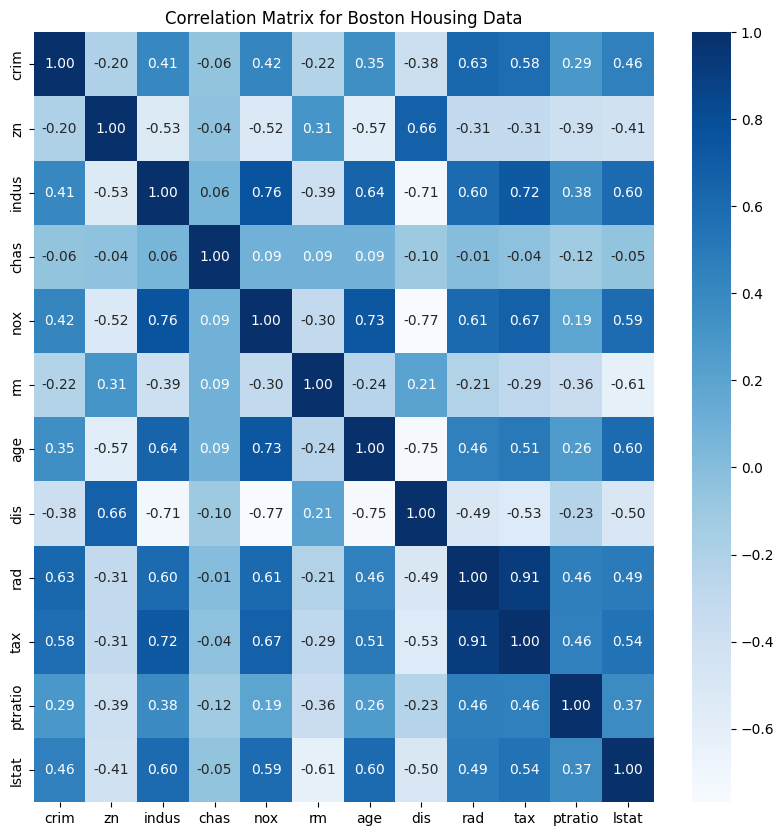

In [5]:
corr_df = boston.drop(['medv'], axis=1, inplace=False).corr()
cols = corr_df.columns

# My approach with sns.heatmap:
plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, fmt='.2F', cmap='Blues',
            xticklabels=cols,
            yticklabels=cols)
plt.title('Correlation Matrix for Boston Housing Data')
plt.show()

*Note that tax and rad are very highly correlated.*

In [6]:
((corr_df > 0.85) & (corr_df < 1.0)).any().any()

np.True_

In [7]:
corr_df[(corr_df > 0.85) & (corr_df < 1.0)].dropna(axis=1, how='all').dropna(axis=0, how='all')

,rad,tax
rad,NaN,0.910228
tax,0.910228,NaN


We start by using the sm.OLS() function to fit a simple linear regression sm.OLS()
model. Our response will be medv and lstat will be the single predictor.
For this model, we can create the model matrix by hand.

In [8]:
# sm.OLS() does not automatically add intercept, so add manually: or see statsmodels.tools.add_constant

X = pd.DataFrame({'intercept': np.ones(boston.shape[0]), 'lstat': boston['lstat']})

print(X.head())


# or just use statsmodels.tools.add_constant

X = sm.add_constant(X)
print('\n',X.head())

   intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94
4        1.0   5.33

    intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94
4        1.0   5.33


We extract the response, and fit the model.

In [9]:
y = boston['medv']
model = sm.OLS(y, X)
results = model.fit()

In [10]:
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [11]:
# ISLP tool ModelSpec uses sklearn

design = MS(['lstat'])
design = design.fit(boston)
X = design.transform(boston)

In [12]:
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In this simple case, the fit() method does very little; it simply checks that
the variable 'lstat' specified in design exists in Boston. Then transform()
constructs the model matrix with two columns: an intercept and the vari-
able lstat.
These two operations can be combined with the fit_transform() method. 

In [13]:
design  = MS(['lstat'])
X = design.fit_transform(boston)
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


Let’s return to our fitted regression model using sm.OLS(). The object results has several
methods that can be used for inference. We already presented a function
summarize() for showing the essentials of the fit. For a full and somewhat
exhaustive summary of the fit, we can use the summary() method (output
not shown).

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           5.08e-88
Time:                        12:41:34   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

The get_prediction() method can be used to obtain predictions, and .get_
produce confidence intervals and prediction intervals for the prediction of
medv for given values of lstat.

We first create a new data frame, in this case containing only the vari-
able lstat, with the values for this variable at which we wish to make
predictions. We then use the transform() method of design to create the
corresponding model matrix.

In [16]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [17]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

Confidence Interval: Estimates the range of the mean response for a given 
x-value; narrower due to only accounting for model uncertainty.

Prediction Interval: Estimates the range for an individual response for a given 
x-value; wider because it includes both model uncertainty and data variability.

In [18]:
# Confidence intervals on predictions:
new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [19]:
# Prediction intervals by setting obs=True:
new_predictions.conf_int(alpha=0.05, obs=True)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

In [20]:
def abline(ax, b ,m, *args, **kwargs):
    "Add a line with slope m and int b to ax"
    xlim = ax.get_xlim()
    ylim = [m * x + b for x in xlim]
    ax.plot(xlim, ylim, *args, **kwargs)

# can also user builtin function ax.axline()

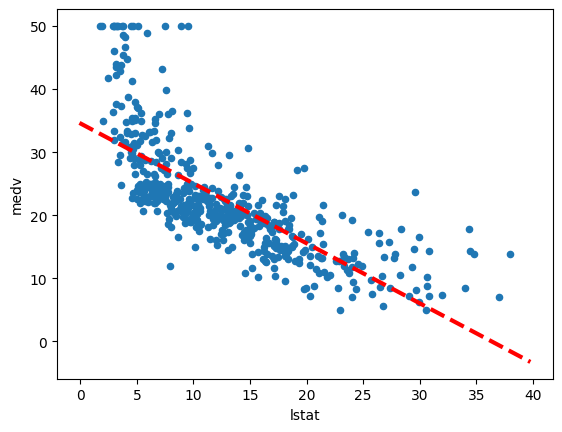

In [21]:
ax = boston.plot.scatter('lstat', 'medv')
abline(
    ax,
    results.params.iloc[0],
    results.params.iloc[1],
    'r--',
    linewidth=3
)

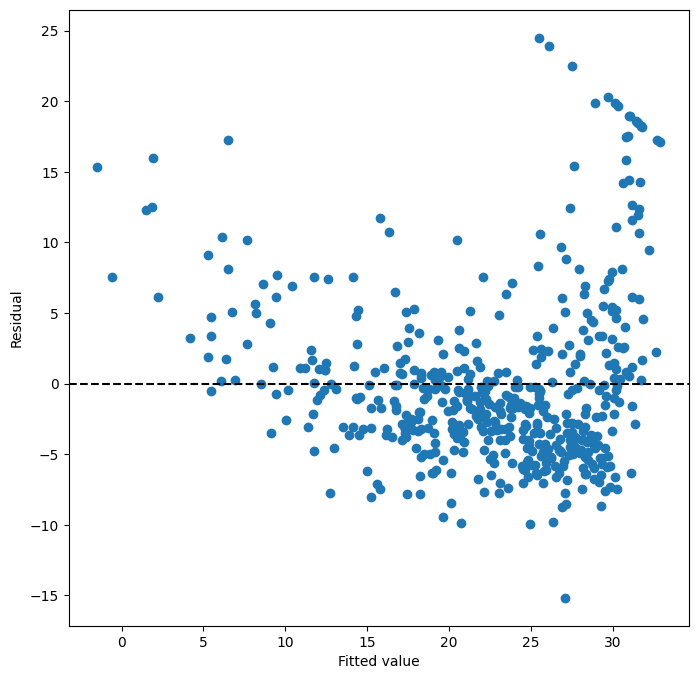

In [22]:
fig, ax = plt.subplots(figsize =(8 ,8))
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel ('Residual')
ax.axhline(0, c='k', ls='--')

On the basis of the residual plot (above), there is some evidence
of non-linearity. Leverage statistics can be computed for any number of
predictors using the hat_matrix_diag attribute of the value returned by the
get_influence() method.

The hat matrix, H, is a projection matrix that maps the observed dependent variable values (y) to the fitted values (y_hat):

y_hat = Hy

A high leverage value indicates that an observation is "far away" in the predictor space and has a strong influence on the regression results.

The rule of thumb is that an observation is considered to have high leverage if h_ii > 2p/n where p is number of predictors (including the intercept) and n is number of observations.

So, for this example: 2*2/506 = 0.008


np.int64(374)

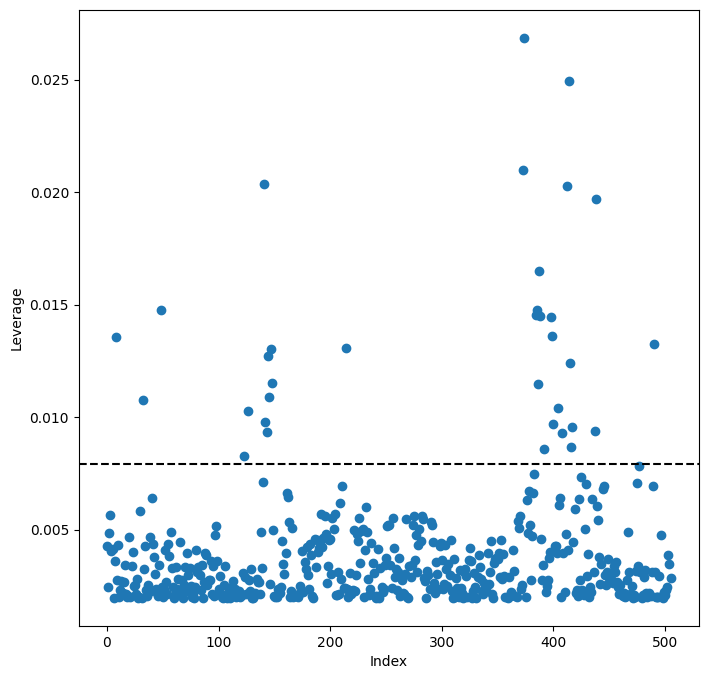

In [23]:
n = results.nobs
p = results.df_model + 1

infl = results.get_influence()
ax = plt.subplots(figsize =(8 ,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
ax.axhline(2*p/n, c='k', ls='--')
np.argmax(infl.hat_matrix_diag)

In [24]:
np.argmax(infl.hat_matrix_diag)

np.int64(374)

## Multiple Linear Regression

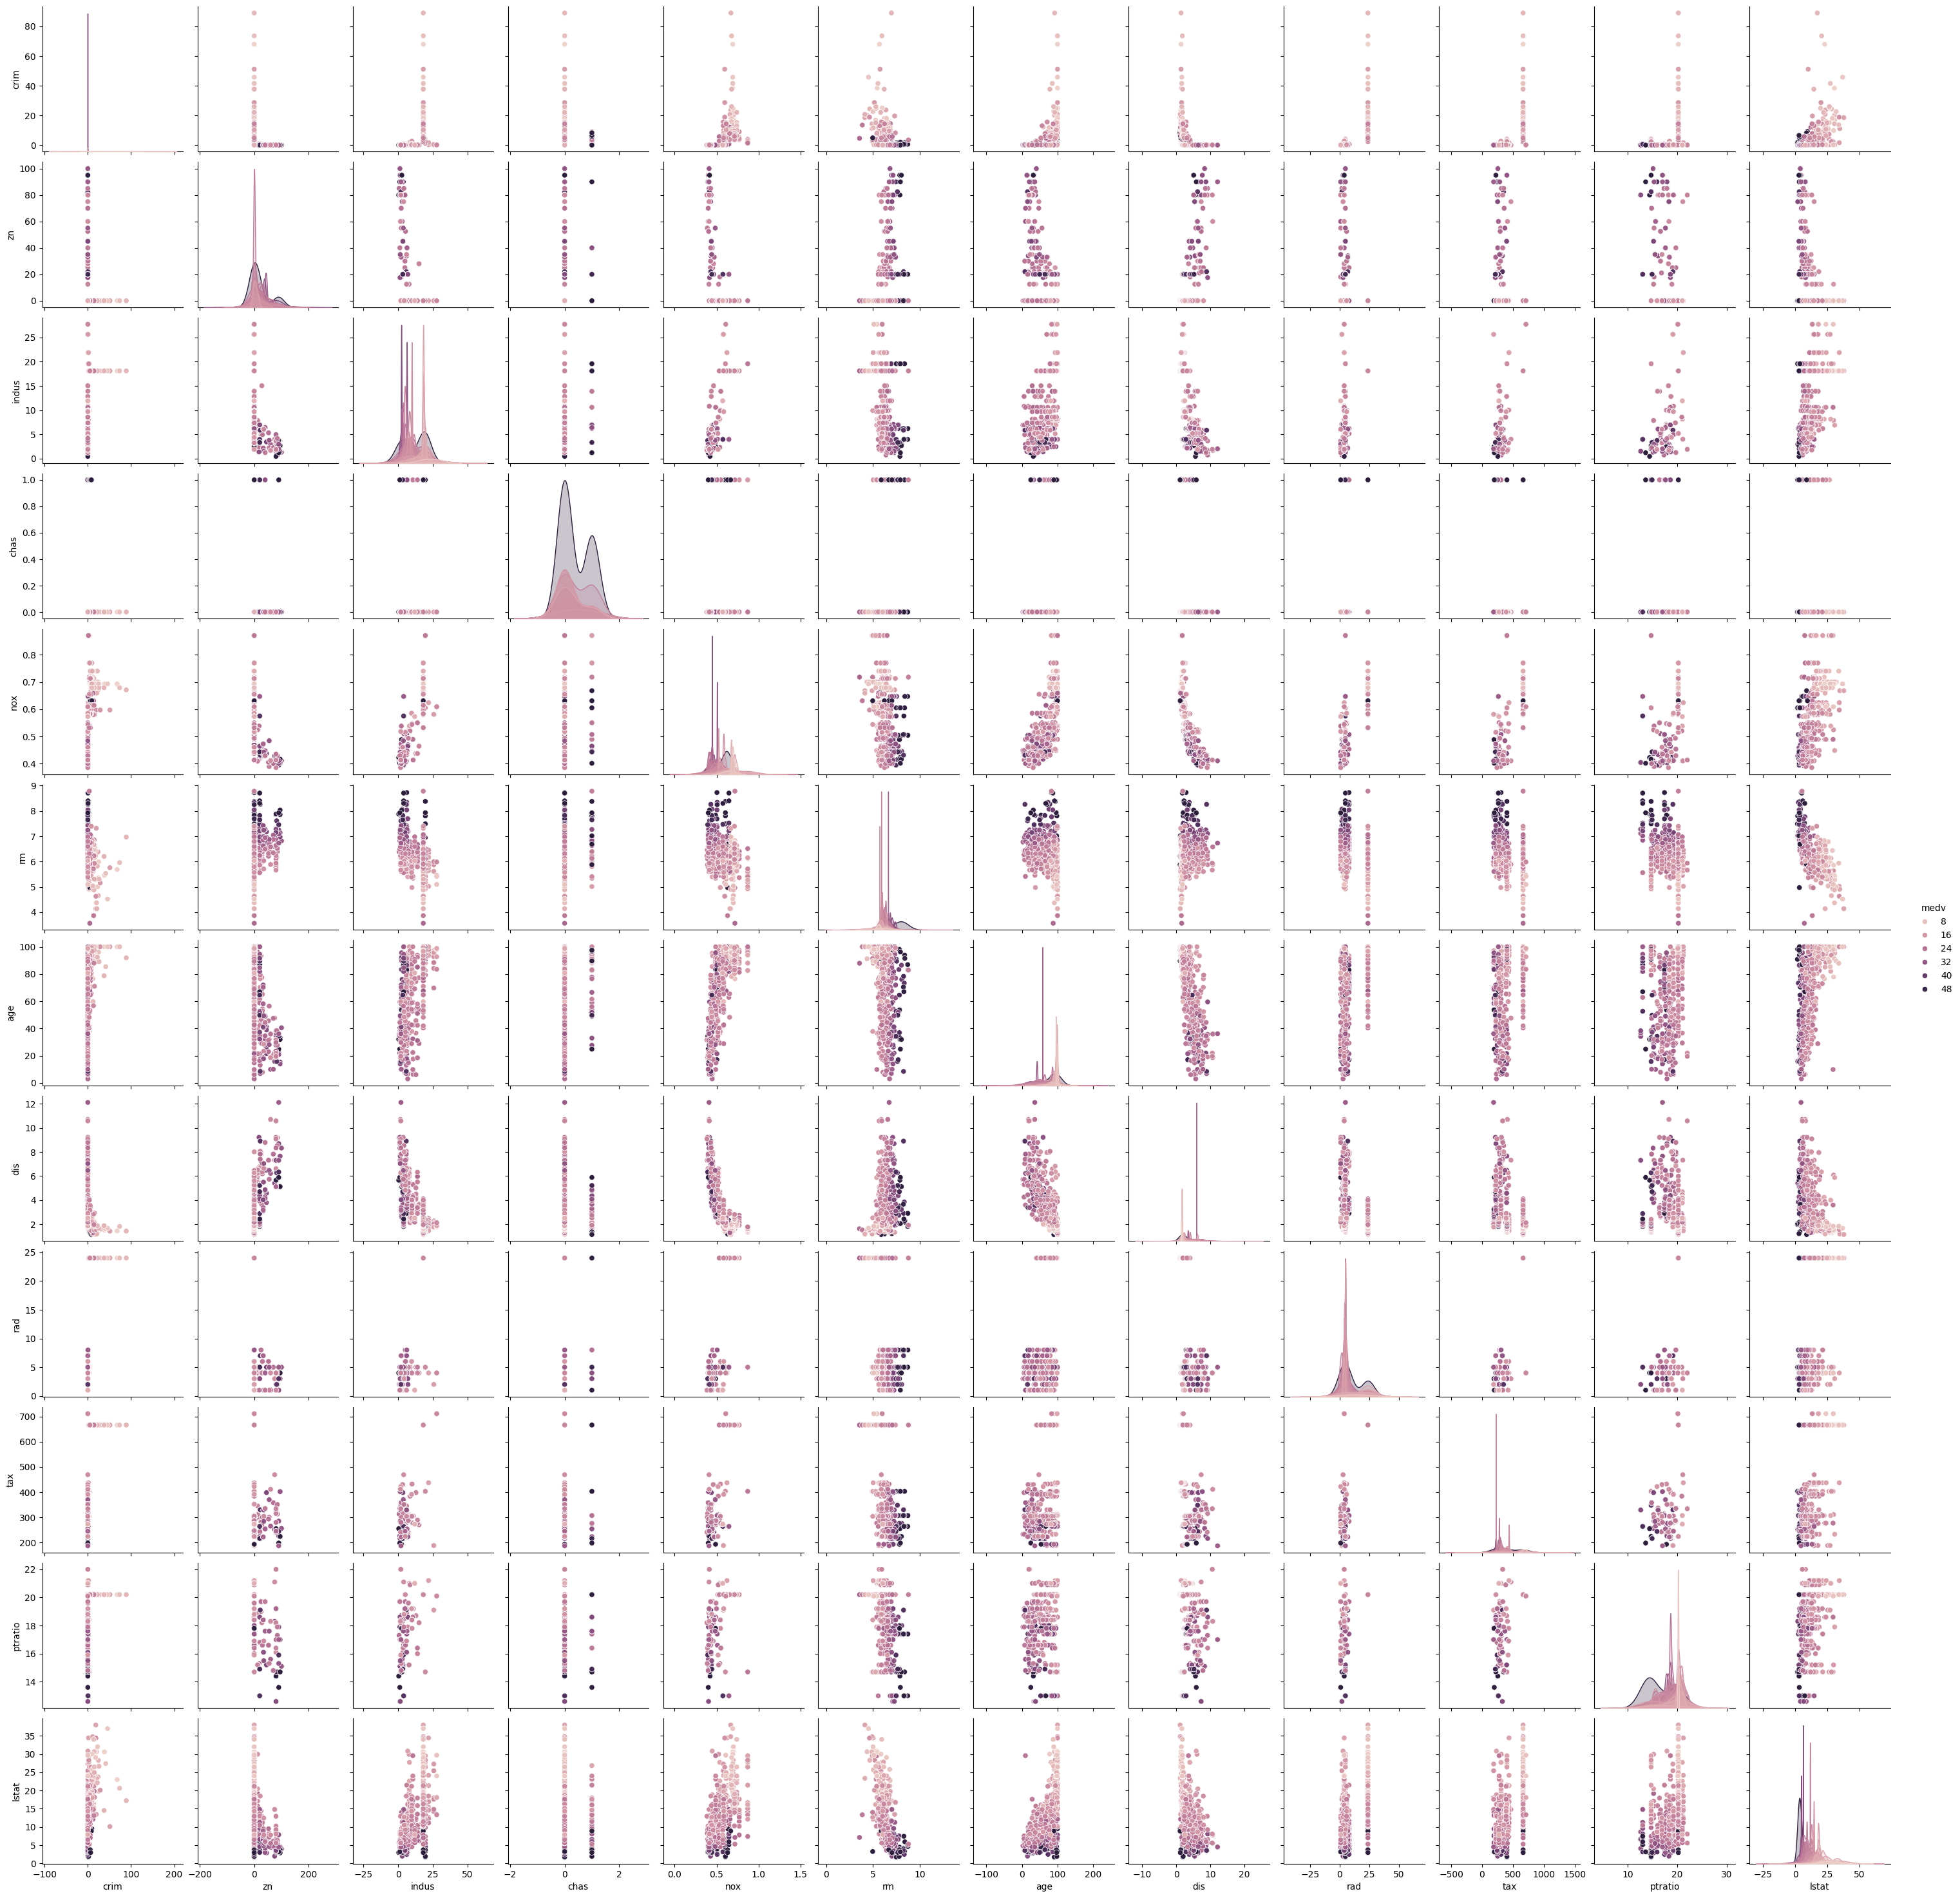

In [25]:
# Look at the pair plots first:

sns.pairplot(boston, diag_kind="kde", hue='medv')

In [26]:
# Try two features:

X = MS(['lstat', 'age']).fit_transform(boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [27]:
terms = boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [28]:
# All features:

y = boston['medv']
X = MS(terms).fit_transform(boston)
model_all = sm.OLS(y, X)
results_all = model_all.fit()
summarize(results_all)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [29]:
results_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          2.23e-133
Time:                        12:41:47   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.6173      4.936      8.431      0.000      31.919      51.316
crim          -0.1214      0.033     -3.678      0.000      -0.186      -0.057
zn             0.0470      0.014      3.384      0.001       0.020       0.074
indus          0.0135      0.062      0.217      0.829      -0.109       0.136
chas           2.8400      0.870      3.264      0.001       1.131       4.549
nox          -18.7580      3.851     -4.870      0.000     -26.325     -11.191
rm             3.6581      0.420      8.705      0.000       2.832       4.484
age            0.0036      0.013      0.271      0.787      -0.023       0.030
dis           -1.4908      0.202     -7.394      0.000      -1.887      -1.095
rad            0.2894      0.067      4.325      0.000       0.158       0.421
tax           -0.0127      0.004     -3.337      0.001      -0.020      -0.005
ptratio       -0.9375      0.132     -7.091      0.000      -1.197      -0.678
lstat         -0.5520      0.051    -10.897      0.000      -0.652      -0.452
==============================================================================
Omnibus:                      171.096   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.937
Skew:                           1.477   Prob(JB):                    6.90e-155
Kurtosis:                       7.995   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Potential problems with linear regression models

When we fit a linear regression model to a particular data set, many prob-
lems may occur. Most common among these are the following:
1. Non-linearity of the response-predictor relationships. (residual plots)
2. Correlation of error terms. (frequent in time series; plot residuals and look for pattern.)
3. Non-constant variance of error terms. (heteroscedasticity indicated by cone shape in residual plot)
4. Outliers. (IQR, Chauvenets, LOF, etc)
5. High-leverage points. (Highest with x most unlike others)
6. Collinearity. (two or more predictor variables are closely related to one another; look at corr matrix; use variance inflation factor (VIF) for multicollinearity; address by dropping one, combining, regularization (ridge or lasso), or centering)


### Variance Inflation Factor (VIF)

VIF(xi)= 1/(1-Ri^2) where Ri2 is the coefficient of determination from a regression where xi is the dependent variable and all other predictors are independent variables.

VIF=1: No multicollinearity. The predictor is completely independent of other predictors.

1 < VIF < 5: Moderate multicollinearity. This is generally considered acceptable.

VIF≥5: High multicollinearity. This suggests a problematic level of correlation, which may inflate variances and make coefficient estimates unstable.

VIF>10: Very high multicollinearity, often considered a strong indication that the variable should be removed or combined with others.



In [30]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]

vif = pd.DataFrame({'vif': vals}, index=X.columns[1:]) # exclude intercept col
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


VIF > 5: rad and tax, which we already we know are correlated with one another from our correlation matrix.

<Axes: xlabel='rad', ylabel='tax'>

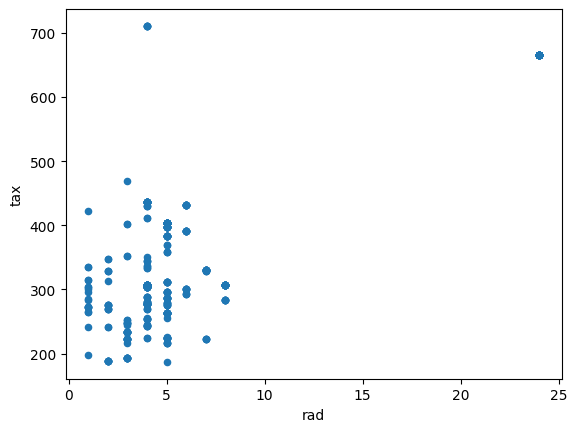

In [31]:
boston.plot.scatter('rad', 'tax')

## Interaction terms

In [32]:
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(boston)
X

,intercept,lstat,age,lstat:age
0,1.0,4.98,65.2,324.696
1,1.0,9.14,78.9,721.146
2,1.0,4.03,61.1,246.233
3,1.0,2.94,45.8,134.652
4,1.0,5.33,54.2,288.886
...,...,...,...,...
501,1.0,9.67,69.1,668.197
502,1.0,9.08,76.7,696.436
503,1.0,5.64,91.0,513.240
504,1.0,6.48,89.3,578.664


In [33]:
model2 = sm.OLS(y, X)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


## Non-Linear Transformations of the Predictors

Using raw polynomials of the underlying features can lead to multicollinearity, as they are often highly correlated. This can inflate the variance of coefficient estimates, making the model less stable and harder to interpret.

One approach to address this is to use orthogonal polynomials, which decorrelate the polynomial terms while preserving the predictive power of the model.



The ISLP `poly()` method automatically creates orthogonal polynomials unless `raw=True` is passed, in which case you'd just get `feature1` and `feature1**2`, etc. This mimics R's poly() func which uses QR decomposition, similar to 

Can also use Legendre polynomials or implement in statsmodels:

```
import statsmodels.formula.api as smf # uses patsy internal, inspired by and compatible with formula mini-language used in R.

model = smf.ols(formula='y ~ bs(x, degree=2, include_intercept=True)', data=df).fit()
```
Scikit-learn's `PolynomialFeatures` does not directly provide orthogonal polynomials, but you can use other preprocessing techniques (e.g., PCA on polynomial terms) to achieve decorrelation. Alternatively, libraries like `numpy.polynomial` can generate orthogonal polynomials.


In [34]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(boston)
X

,intercept,"poly(lstat, degree=2)[0]","poly(lstat, degree=2)[1]",age
0,1.0,-0.047815,0.038955,65.2
1,1.0,-0.021892,-0.010782,78.9
2,1.0,-0.053734,0.053604,61.1
3,1.0,-0.060527,0.071920,45.8
4,1.0,-0.045634,0.033866,54.2
...,...,...,...,...
501,1.0,-0.018589,-0.015433,69.1
502,1.0,-0.022265,-0.010231,76.7
503,1.0,-0.043702,0.029497,91.0
504,1.0,-0.038467,0.018316,89.3


In [35]:
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


In [36]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     337.3
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          7.03e-120
Time:                        12:41:47   Log-Likelihood:                -1561.0
No. Observations:                 506   AIC:                             3130.
Df Residuals:                     502   BIC:                             3147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   17.7151      0.781     22.681      0.000      16.181      19.250
poly(lstat, degree=2)[0]  -179.2279      6.733    -26.620      0.000    -192.456    -166.000
poly(lstat, degree=2)[1]    72.9908      5.482     13.315      0.000      62.220      83.761
age                          0.0703      0.011      6.471      0.000       0.049       0.092
==============================================================================
Omnibus:                       81.499   Durbin-Watson:                   1.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.528
Skew:                           0.918   Prob(JB):                     1.69e-34
Kurtosis:                       5.001   Cond. No.                     2.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Here results1 represents the linear submodel containing predictors lstat
and age, while results3 corresponds to the larger model above with a
quadratic term in lstat. The anova_lm() function performs a hypothesis
test comparing the two models. The null hypothesis is that the quadratic
term in the bigger model is not needed, and the alternative hypothesis is
that the bigger model is superior. Here the F-statistic is 177.28 and the
associated p-value is zero. In this case the F-statistic is the square of the
t-statistic for the quadratic term in the linear model summary for results3
— a consequence of the fact that these nested models differ by one degree of
freedom. This provides very clear evidence that the quadratic polynomial
in lstat improves the linear model. This is not surprising, since earlier we
saw evidence for non-linearity in the relationship between medv and lstat.
The function anova_lm() can take more than two nested models as input,
in which case it compares every successive pair of models. That also explains
why their are NaNs in the first row above, since there is no previous model
with which to compare the first.

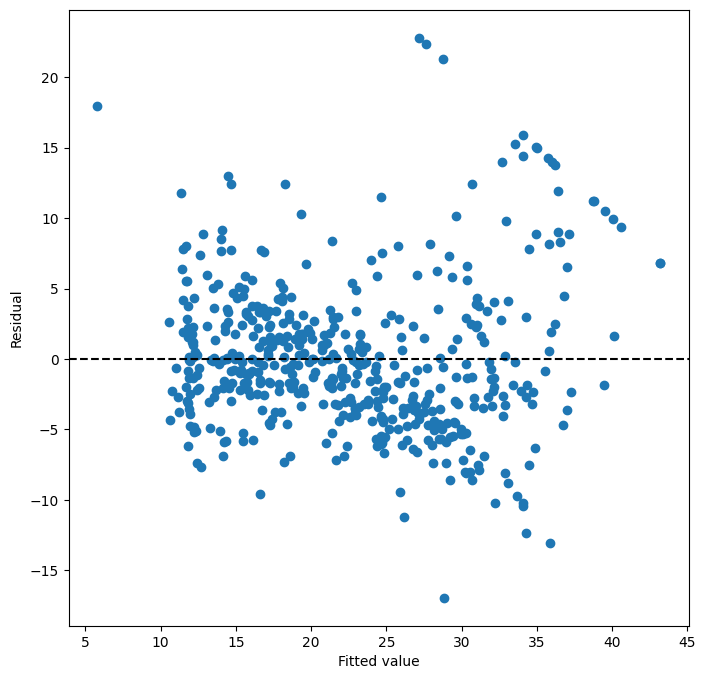

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter( results3 .fittedvalues , results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline (0, c='k', ls='--')

## Qualitative Predictors

In [39]:
carseats = load_data('Carseats')
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


In [66]:
carseats.describe(include='all')

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400,400.000000,400.000000,400,400
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,Medium,NaN,NaN,Yes,Yes
freq,NaN,NaN,NaN,NaN,NaN,NaN,219,NaN,NaN,282,258
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,NaN,53.322500,13.900000,NaN,NaN
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,NaN,16.200297,2.620528,NaN,NaN
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,NaN,25.000000,10.000000,NaN,NaN
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,NaN,39.750000,12.000000,NaN,NaN
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,NaN,54.500000,14.000000,NaN,NaN
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,NaN,66.000000,16.000000,NaN,NaN


In [55]:
# Inspect the values for categorical columns:

for col in carseats.columns:
    if not is_numeric_dtype(carseats[col]):
        uniques = carseats[col].unique().tolist()
        print(f'{col}: {uniques}')


ShelveLoc: ['Bad', 'Good', 'Medium']
Urban: ['Yes', 'No']
US: ['Yes', 'No']


In [67]:
X

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,138,73,11,276,120,Bad,42,17,Yes,Yes
1,111,48,16,260,83,Good,65,10,Yes,Yes
2,113,35,10,269,80,Medium,59,12,Yes,Yes
3,117,100,4,466,97,Medium,55,14,Yes,Yes
4,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,Good,33,14,Yes,Yes
396,139,23,3,37,120,Medium,55,11,No,Yes
397,162,26,12,368,159,Medium,40,18,Yes,Yes
398,100,79,7,284,95,Bad,50,12,Yes,Yes


In [72]:
allvars = list(carseats.columns.drop('Sales'))
y = carseats['Sales']
X = carseats[allvars]
final = allvars + [('Income', 'Advertising'), ('Price', 'Age')] # add two interaction terms

X = MS(final).fit_transform(carseats)
model = sm.OLS(y,X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


Notice how the model matrix builder created dummy variables for the categorical attributes.

In [73]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          6.14e-166
Time:                        13:05:24   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept              6.5756      1.009      6.519      0.000       4.592       8.559
CompPrice              0.0929      0.004     22.567      0.000       0.085       0.101
Income                 0.0109      0.003      4.183      0.000       0.006       0.016
Advertising            0.0702      0.023      3.107      0.002       0.026       0.115
Population             0.0002      0.000      0.433      0.665      -0.001       0.001
Price                 -0.1008      0.007    -13.549      0.000      -0.115      -0.086
ShelveLoc[Good]        4.8487      0.153     31.724      0.000       4.548       5.149
ShelveLoc[Medium]      1.9533      0.126     15.531      0.000       1.706       2.201
Age                   -0.0579      0.016     -3.633      0.000      -0.089      -0.027
Education             -0.0209      0.020     -1.063      0.288      -0.059       0.018
Urban[Yes]             0.1402      0.112      1.247      0.213      -0.081       0.361
US[Yes]               -0.1576      0.149     -1.058      0.291      -0.450       0.135
Income:Advertising     0.0008      0.000      2.698      0.007       0.000       0.001
Price:Age              0.0001      0.000      0.801      0.424      -0.000       0.000
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.147
Skew:                           0.129   Prob(JB):                        0.564
Kurtosis:                       3.050   Cond. No.                     1.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Random note:

matrix multiplication: AB = C
If A is an m x n matrix and B is an n x p matrix, the matrix product C is an m x p matrix. Ie, the number of columns of A must equal number of rows of B.